In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries

import math
import os
import sys

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Scikit-learn
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
# Keras
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv1D, Dropout, Activation, Flatten
from keras.metrics import AUC
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import Sequence

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

# Local imports
from models import Attia_et_al_CNN

# Environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from utils import split_train_val_test, load_X_y

/tmp/ipykernel_770160/914770412.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-23 12:53:45.940019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 12:53:45.940049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 12:53:45.940974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable

load data

In [3]:
conditions = ['1AVB', 'AF', 'AFIB', 'APB', 'AQW', 'IDC',
              'LVH', 'LVQRSAL', 'RBBB', 'SR', 'ST',
              'STDD', 'STE', 'STTC', 'SVT', 'TWC',
              'TWO']

data_df = pd.read_pickle('data/arrythmia_dataset.pickle')

X, y = data_df['wf'].to_numpy(), data_df[conditions].to_numpy()
y = y.astype(float)
X = np.stack(X, axis=0)

del data_df

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(X, y, train_size=0.7, val_size=0.15)
del X, y, X_train, y_train, X_val, y_val


Single lead models

In [4]:
lead_labels = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# lead_labels = ['I']

# Initialize a pandas df
df = pd.DataFrame(columns=['baseline'] + lead_labels, index=conditions + ['Avg'], dtype=float)

for lead in lead_labels:
    print(f"Lead: {lead}")
    lead_idx = lead_labels.index(lead)
    X_test_lead = X_test[:, :, lead_idx].copy()
    X_test_lead = X_test_lead.reshape(-1, 5000, 1)

    model_path = f"models/single-lead/mult_output_cnn_{lead}.keras"
    model = keras.saving.load_model(model_path)
    y_pred = model.predict(X_test_lead, verbose=0)

    for i, condition in enumerate(conditions):
        auc = roc_auc_score(y_test[:,i], y_pred[:,i])
        # print(f"{condition}: {auc}")

        df.loc[condition, lead] = auc

Lead: I


2024-04-23 12:54:57.315080: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 12:54:57.345967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-23 12:54:57.346271: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Lead: II
Lead: III
Lead: aVR
Lead: aVF
Lead: aVL
Lead: V1
Lead: V2
Lead: V3
Lead: V4
Lead: V5
Lead: V6


In [5]:
model_path = f"models/12-lead/multi_output_cnn.keras"
model = keras.saving.load_model(model_path)
pred = model.predict(X_test, verbose=0)

for i, condition in enumerate(conditions):
    auc = roc_auc_score(y_test[:,i], pred[:,i])
    print(f"{condition}: {auc}")

    df.loc[condition, 'baseline'] = auc

1AVB: 0.9638099347909475
AF: 0.9681221354801401
AFIB: 0.9240833028964911
APB: 0.8140585378049217
AQW: 0.7729185460195956
IDC: 0.8682842597013194
LVH: 0.9632228638854536
LVQRSAL: 0.7586582659080876
RBBB: 0.8670345295399106
SR: 0.9854833493522901
ST: 0.9967942732648615
STDD: 0.9418983971992128
STE: 0.6623381511592894
STTC: 0.8628587479865345
SVT: 0.9931811101752605
TWC: 0.9027098891581643
TWO: 0.9339386767157303


In [6]:
# conditions = ['1AVB', 'AF', 'AFIB', 'APB', 'AQW', 'IDC',
#               'LVH', 'LVQRSAL', 'RBBB', 'SR', 'ST',
#               'STDD', 'STE', 'STTC', 'SVT', 'TWC',
#               'TWO']


condition_mapping = {
    '1AVB': '1st degree atrioventricular block',
    'AF': 'Atrial flutter',
    'AFIB': 'Atrial fibrillation',
    'APB': 'Atrial premature beat',
    'AQW': 'Abnormal Q wave',
    # 'ARS': 'Axis right shift',
    'IDC': 'Interior differences conduction',
    'LVH': 'Left ventricular hypertrophy',
    'LVQRSAL': 'Lower voltage QRS in all lead',
    'RBBB': 'Right bundle branch block',
    # 'SA': 'Sinus Irregularity',
    'SB': 'Sinus bradycardia',
    'ST': 'Sinus tachycardia',
    'STDD': 'ST depression',
    'STE': 'ST extension',
    'STTC': 'ST-T wave change',
    'SVT': 'Supraventricular tachycardia',
    'TWC': 'T wave change',
    'TWO': 'T wave inversion',
    'SR': 'Sinus rhythm',
    'Avg': 'Avg'
}

df.index = [condition_mapping[i] for i in df.index]

df.loc['Avg'] = df.mean(axis=0)

In [7]:
df.to_pickle('cnn_perf_internal.pickle')

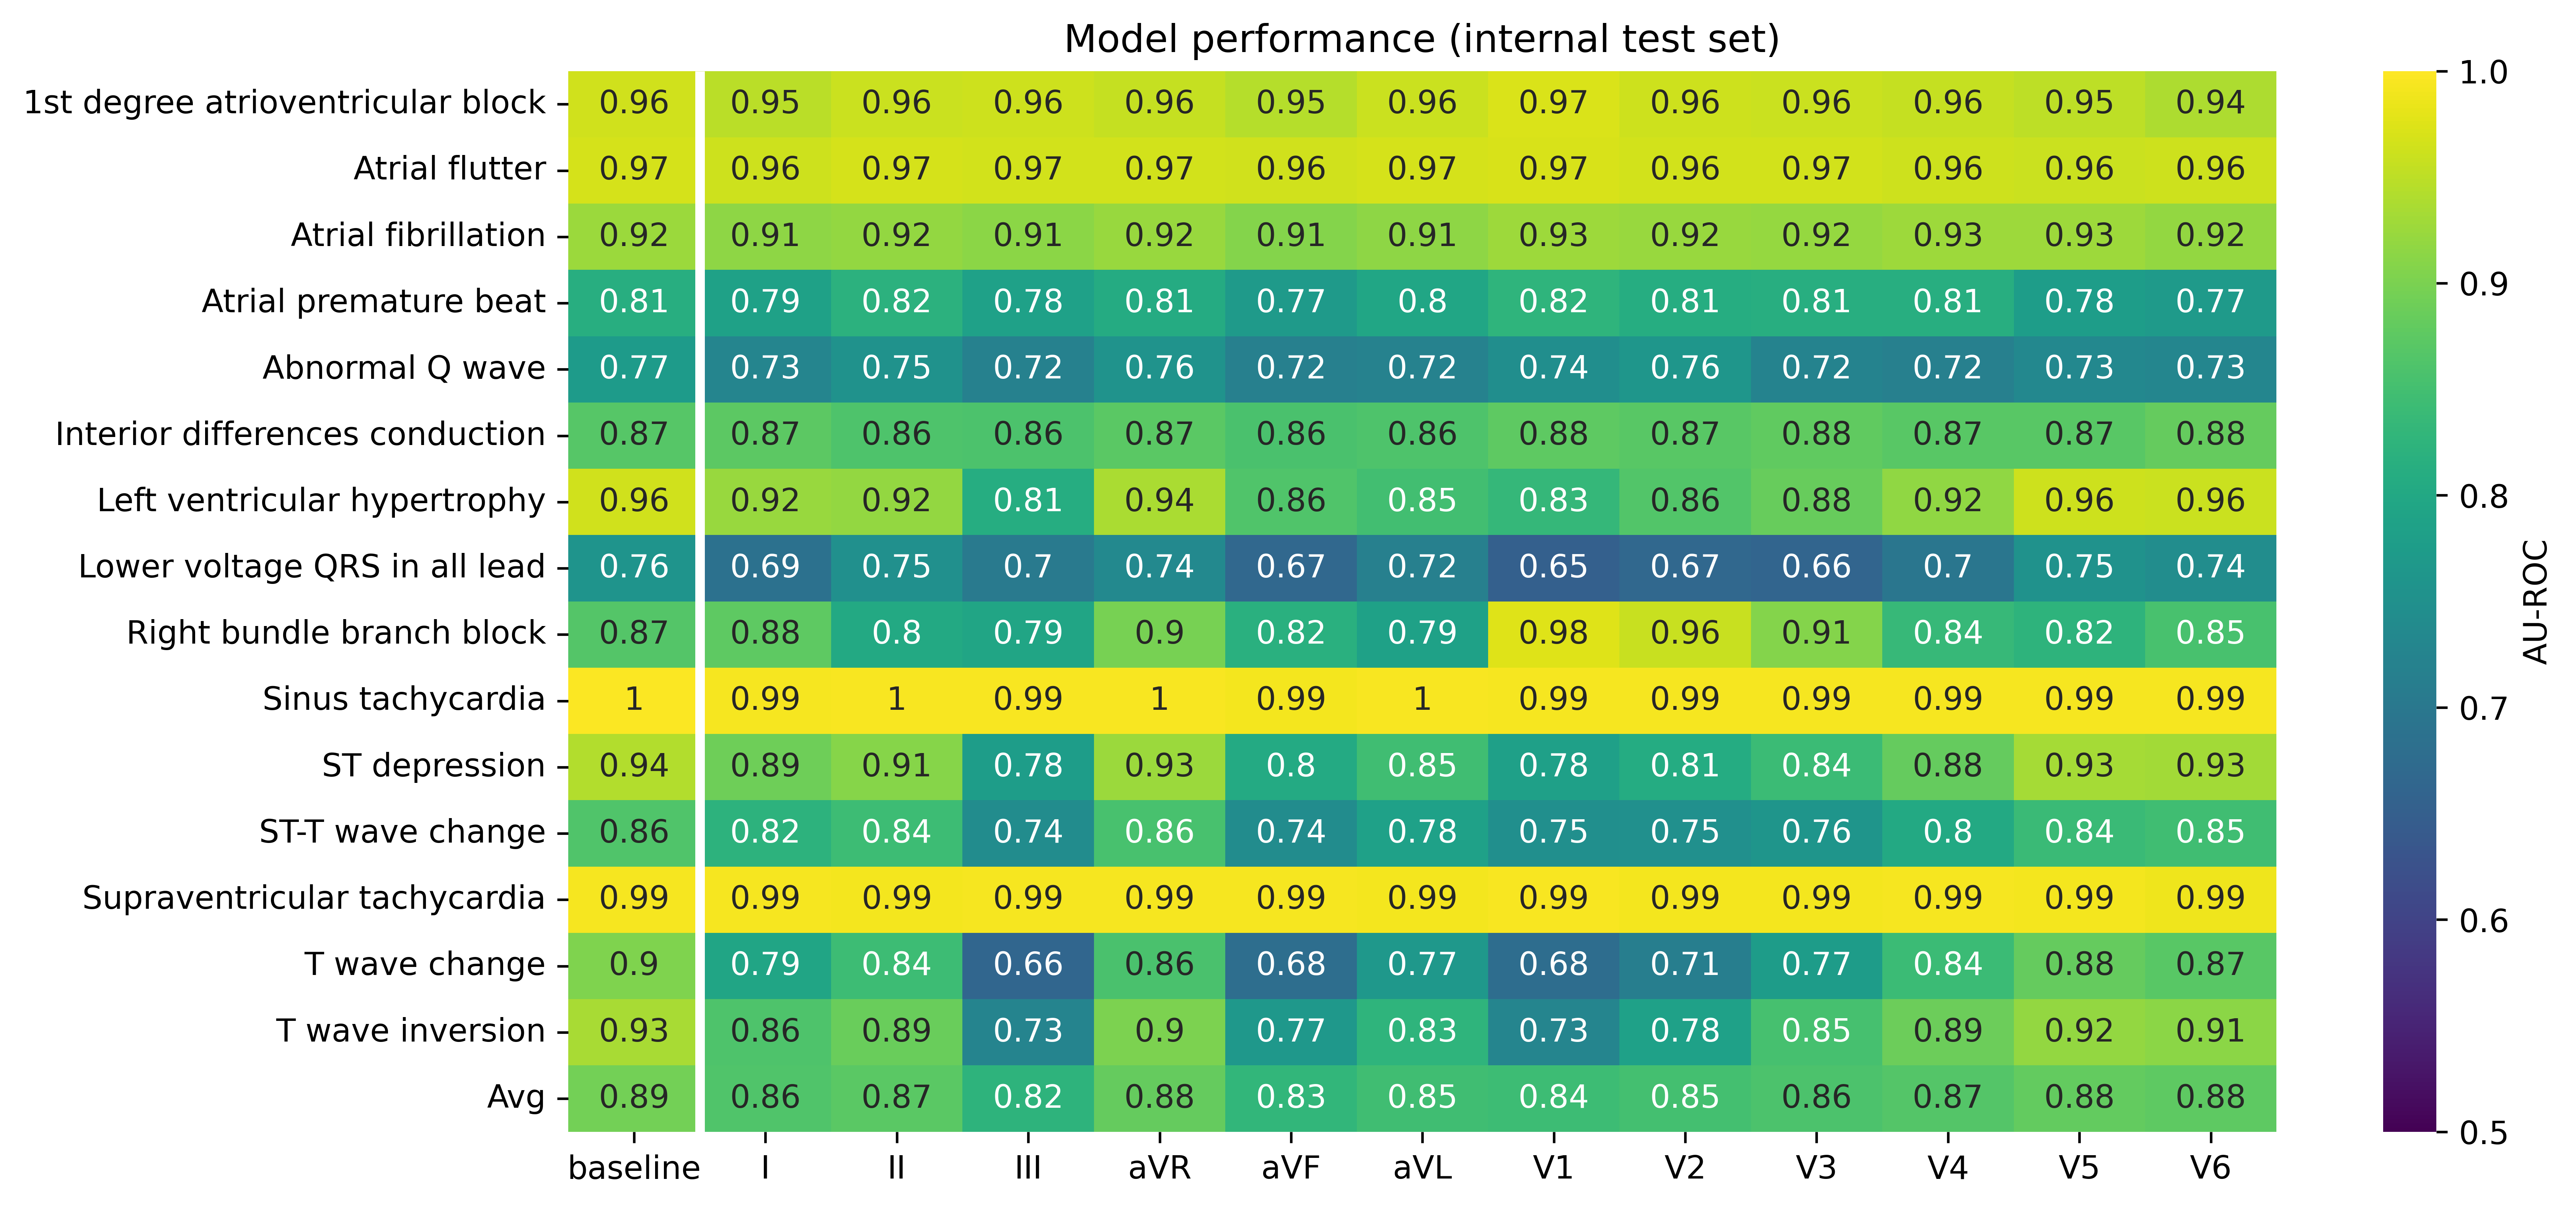

In [8]:
df = df.drop('Sinus rhythm')
df = df.drop('ST extension')

# Create a heatmapx
import seaborn as sns
fig, ax = plt.subplots(figsize = (12, 6), dpi=600)

sns.heatmap(df, annot=True, cmap="viridis", cbar_kws={'label': 'AU-ROC'}, vmin=0.5, vmax=1)
plt.title('Model performance (internal test set)')
b, t = plt.ylim()
ax.vlines(x = 1, ymin = b, ymax = t, colors = 'white', lw = 3)

b, t = plt.xlim()
ax.hlines(y = 17, xmin = b, xmax = t, colors = 'white', lw = 3)

# Save model as pdf

plt.savefig('cnn_perf_internal.pdf', bbox_inches = "tight")
plt.savefig('cnn_perf_internal.png', bbox_inches = "tight", dpi=600)

plt.show()